# Import libraries

In [1]:
import pandas as pd
from torch.utils.data import DataLoader
from dataset import NCFDataset
from recom_ncf import NCFRecommender
from evaluation import Evaluation
from helpers.index_manager import IndexManager
from helpers.mem_map_dataloader import MemMapDataLoader
from helpers.cache import CacheType
from tuner import NCFTuner
from ncf import ModelType
from helpers.dataloader_custom_functions import collate_fn, worker_init_fn
import numpy as np

# Loading data

In [2]:
df_train = pd.read_csv('../data/train-leave2.csv')
df_val = pd.read_csv('../data/val-leave2.csv')
df_test = pd.read_csv('../data/test-leave2.csv')
df_features = pd.read_csv('../data/metadata.csv')
index_manager = IndexManager()
index_manager.load('../data/index.pkl')

In [3]:
image_dataloader = MemMapDataLoader(file_dir='D:/frame-features', index_manager=index_manager, cache_type=CacheType.UNLIMITED)

# Tuning model

In [4]:
unique_users = index_manager.get_indexed_values('user_id')
unique_items = index_manager.get_indexed_values('item_id')

tuner = NCFTuner(
    train_data=df_train,
    val_data=df_val,
    test_data=df_test,
    unique_users=unique_users,
    unique_items=unique_items,
    image_dataloader=image_dataloader,
    model_type=ModelType.LATE_FUSION,
)

In [5]:
param_grid = {
            'factors': [16, 32, 64, 128],
            'mlp_user_item_dim': [16, 32, 64, 128],
            'learning_rate': np.random.uniform(0.00001, 0.001, size=30),
            'epochs': [10, 15, 20],
            'optimizer': ['adagrad', 'adam', 'sgd'],
            'dropout': [0.0, 0.1, 0.2, 0.5],
            'weight_decay': np.random.uniform(0.0001, 0.1, size=30),
            'loss_fn': ['mse', 'bce'],
            'batch_size': [2048, 4096],
            'image_dim': [128, 256, 512]
}

tuner.set_param_grid(param_grid)

In [6]:
results, file_path = tuner.perform_random_search(num_trials=30, result_file='tuning_results/checkpoint.json')

Running experiment with params: {'factors': 64, 'mlp_user_item_dim': 32, 'learning_rate': 0.00016858458787576212, 'epochs': 20, 'optimizer': 'sgd', 'dropout': 0.1, 'weight_decay': 0.03599317489468881, 'loss_fn': 'bce', 'batch_size': 4096, 'image_dim': 128}
Epoch 1/20
Train loss: 0.666119, Validation loss: 0.675875
Epoch 2/20
Train loss: 0.662883, Validation loss: 0.674015
Epoch 3/20
Train loss: 0.659718, Validation loss: 0.672215
Epoch 4/20
Train loss: 0.656656, Validation loss: 0.670469
Epoch 5/20
Train loss: 0.653633, Validation loss: 0.668772
Epoch 6/20
Train loss: 0.650686, Validation loss: 0.667129
Epoch 7/20
Train loss: 0.647809, Validation loss: 0.665536
Epoch 8/20
Train loss: 0.644981, Validation loss: 0.663989
Epoch 9/20
Train loss: 0.642236, Validation loss: 0.662493
Epoch 10/20
Train loss: 0.639528, Validation loss: 0.661037
Epoch 11/20
Train loss: 0.636905, Validation loss: 0.659631
Epoch 12/20
Train loss: 0.634324, Validation loss: 0.658264
Epoch 13/20
Train loss: 0.631813

In [7]:
best_params = tuner.analyze_results()
print("Best parameters:", best_params)

Best parameters: {'Hit Ratio@10': {'params': {'factors': 32, 'mlp_user_item_dim': 64, 'learning_rate': 0.0008112776425528898, 'epochs': 20, 'optimizer': 'adagrad', 'dropout': 0.5, 'weight_decay': 0.09953702997298719, 'loss_fn': 'mse', 'batch_size': 4096, 'image_dim': 512}, 'value': 0.0017422461826728686}, 'NDCG@10': {'params': {'factors': 32, 'mlp_user_item_dim': 64, 'learning_rate': 0.0008112776425528898, 'epochs': 20, 'optimizer': 'adagrad', 'dropout': 0.5, 'weight_decay': 0.09953702997298719, 'loss_fn': 'mse', 'batch_size': 4096, 'image_dim': 512}, 'value': 0.0015677441940620972}, 'Recall@10': {'params': {'factors': 32, 'mlp_user_item_dim': 64, 'learning_rate': 0.0008112776425528898, 'epochs': 20, 'optimizer': 'adagrad', 'dropout': 0.5, 'weight_decay': 0.09953702997298719, 'loss_fn': 'mse', 'batch_size': 4096, 'image_dim': 512}, 'value': 0.0017422461826728686}}


# Analyzing results

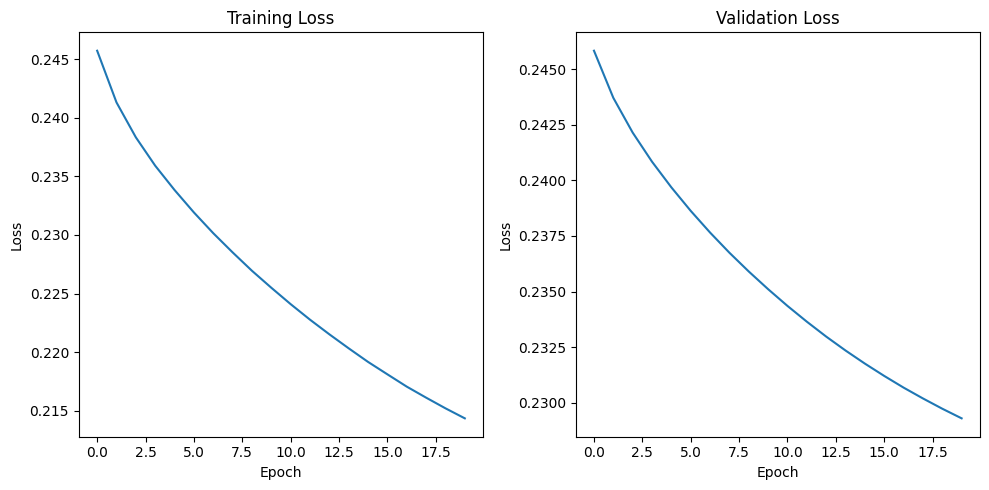

In [8]:
df_result = tuner.plot_results()

In [9]:
df_result

,factors,mlp_user_item_dim,learning_rate,epochs,optimizer,dropout,weight_decay,loss_fn,batch_size,image_dim,Hit Ratio@10,NDCG@10,Recall@10
0,32,64,0.000811,20,adagrad,0.5,0.099537,mse,4096,512,0.001742,0.001568,0.001742
1,64,128,0.000811,20,adagrad,0.1,0.081214,mse,2048,256,0.001742,0.001568,0.001742
2,64,32,0.000169,20,sgd,0.1,0.035993,bce,4096,128,0.000041,0.000020,0.000041
3,16,16,0.000169,20,sgd,0.5,0.078803,mse,4096,512,0.000033,0.000020,0.000033
4,64,16,0.000995,15,sgd,0.0,0.034026,bce,4096,128,0.000049,0.000018,0.000049
5,128,16,0.000714,15,adagrad,0.2,0.085641,bce,4096,256,0.001520,0.000494,0.001520
6,32,16,0.000346,15,adam,0.2,0.093940,bce,4096,128,0.001742,0.001568,0.001742
7,32,16,0.000169,20,adagrad,0.5,0.033147,mse,2048,128,0.000025,0.000008,0.000025
8,32,16,0.000116,15,sgd,0.2,0.037530,mse,2048,128,0.000090,0.000030,0.000090
9,64,64,0.000983,10,sgd,0.0,0.033356,bce,2048,128,0.000452,0.000150,0.000452


# Train model with best params

In [10]:
best_param = best_params['Hit Ratio@10']['params']
batch_size = best_param.pop('batch_size')

In [11]:
train_dataset = NCFDataset(df_train, image_dataloader=image_dataloader)
val_dataset = NCFDataset(df_val, image_dataloader=image_dataloader)

dataloader_params = {
    'batch_size': batch_size,
    'num_workers': 4,
    'persistent_workers': True,
    'prefetch_factor': 4,
    'pin_memory': True,
    'pin_memory_device': 'cuda',
    'collate_fn': collate_fn,
    'worker_init_fn': worker_init_fn,
}

train_dataloader = DataLoader(train_dataset, shuffle=True, **dataloader_params)
val_dataloader = DataLoader(val_dataset, shuffle=False, **dataloader_params)

model = NCFRecommender(unique_users, unique_items, image_dataloader=image_dataloader, **best_param)
model.fit(train_dataloader, val_dataloader)

Epoch 1/20
Train loss: 0.229836, Validation loss: 0.234979
Epoch 2/20
Train loss: 0.222751, Validation loss: 0.233109
Epoch 3/20
Train loss: 0.220005, Validation loss: 0.232264
Epoch 4/20
Train loss: 0.218083, Validation loss: 0.231688
Epoch 5/20
Train loss: 0.216466, Validation loss: 0.230679
Epoch 6/20
Train loss: 0.215226, Validation loss: 0.230350
Epoch 7/20
Train loss: 0.214019, Validation loss: 0.229899
Epoch 8/20
Train loss: 0.212990, Validation loss: 0.229309
Epoch 9/20
Train loss: 0.212148, Validation loss: 0.229015
Epoch 10/20
Train loss: 0.211286, Validation loss: 0.228487
Epoch 11/20
Train loss: 0.210406, Validation loss: 0.228322
Epoch 12/20
Train loss: 0.209791, Validation loss: 0.227899
Epoch 13/20
Train loss: 0.209156, Validation loss: 0.227611
Epoch 14/20
Train loss: 0.208534, Validation loss: 0.227388
Epoch 15/20
Train loss: 0.207914, Validation loss: 0.227065
Epoch 16/20
Train loss: 0.207450, Validation loss: 0.226830
Epoch 17/20
Train loss: 0.206943, Validation loss

In [12]:
evaluator = Evaluation(recommender=model, test_data=df_test)
metrics = evaluator.evaluate()

Creating ground truth sets...
Generating predictions...
Processing 1 of 121682 users... (0.00%)
Processing 129 of 121682 users... (0.11%)
Processing 257 of 121682 users... (0.21%)
Processing 385 of 121682 users... (0.32%)
Processing 513 of 121682 users... (0.42%)
Processing 641 of 121682 users... (0.53%)
Processing 769 of 121682 users... (0.63%)
Processing 897 of 121682 users... (0.74%)
Processing 1025 of 121682 users... (0.84%)
Processing 1153 of 121682 users... (0.95%)
Processing 1281 of 121682 users... (1.05%)
Processing 1409 of 121682 users... (1.16%)
Processing 1537 of 121682 users... (1.26%)
Processing 1665 of 121682 users... (1.37%)
Processing 1793 of 121682 users... (1.47%)
Processing 1921 of 121682 users... (1.58%)
Processing 2049 of 121682 users... (1.68%)
Processing 2177 of 121682 users... (1.79%)
Processing 2305 of 121682 users... (1.89%)
Processing 2433 of 121682 users... (2.00%)
Processing 2561 of 121682 users... (2.10%)
Processing 2689 of 121682 users... (2.21%)
Processi

In [13]:
for metric in metrics.keys():
    print(f'{metric}:\t{metrics[metric]: .7f}')

Hit Ratio@10:	 0.0000247
NDCG@10:	 0.0000081
Recall@10:	 0.0000247
